In [65]:
import os
import json
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [66]:
def get_doc_texts():
    docs = {}

    with open('../dataset/docs.json', 'r') as docs_file:
        progress_bar = tqdm(total=os.path.getsize('../dataset/docs.json'), unit='B', unit_scale=True, unit_divisor=1024, desc='Loading docs') 

        for line in docs_file:
            doc = json.loads(line)
            docs[doc['id']] = doc['text']
            
            progress_bar.update(len(line))

    return docs

def get_dataset():
    doc_texts = get_doc_texts()

    docs_df = pd.read_csv("../dataset/docs.csv").astype('string')

    batch = []
    for index, row in docs_df.iterrows():
        if not row.doc1_id in doc_texts or not row.doc2_id in doc_texts:
            continue

        batch.append({
            "doc1": {
                "id": row.doc1_id,
                "text": doc_texts[row.doc1_id]
            },
            "doc2": {
                "id": row.doc2_id,
                "text": doc_texts[row.doc2_id]
            },
            "score": float(row.score)
        })

    train, test = train_test_split(batch, test_size=0.2, random_state=42)
    return train, test


In [67]:
train, test = get_dataset()

Loading docs: 100%|█████████████████████████████████████████████████████████████████| 43.7M/43.7M [00:00<00:00, 199MB/s]


In [68]:
import os, sys
sys.path.append(os.path.abspath('..'))

In [69]:
from model.model import SemanticSimilarityModel

In [70]:
similarity_model = SemanticSimilarityModel()
similarity_model.load('with_classifier')

In [71]:
# node id to text dictionary
pos_nodes = {}
neg_nodes = {}

for edge in train:
    if edge['score'] > 0.5:
        pos_nodes[edge['doc1']['id']] = edge['doc1']['text']
        pos_nodes[edge['doc2']['id']] = edge['doc2']['text']
    else:
        neg_nodes[edge['doc1']['id']] = edge['doc1']['text']
        neg_nodes[edge['doc2']['id']] = edge['doc2']['text']

In [72]:
pos_node_id_to_index_map = {node: i for i, node in enumerate(pos_nodes.keys())}
neg_node_id_to_index_map = {node: i for i, node in enumerate(neg_nodes.keys())}

print("pos num_nodes: ", len(pos_nodes))
print("neg num_nodes: ", len(neg_nodes))

pos num_nodes:  4114
neg num_nodes:  2144


In [73]:
import torch
from torch_geometric.data import Data

In [74]:
pos_edges = []
neg_edges = []

for edge in train:

    if edge['score'] > 0.5:
        n1 = pos_node_id_to_index_map[edge['doc1']['id']]
        n2 = pos_node_id_to_index_map[edge['doc2']['id']]
        pos_edges.append([n1, n2])
        pos_edges.append([n2, n1])
    else:
        n1 = neg_node_id_to_index_map[edge['doc1']['id']]
        n2 = neg_node_id_to_index_map[edge['doc2']['id']]
        neg_edges.append([n1, n2])
        neg_edges.append([n2, n1])

pos_edges_tensor = torch.tensor(pos_edges, dtype=torch.long).t().contiguous()
neg_edges_tensor = torch.tensor(neg_edges, dtype=torch.long).t().contiguous()

In [75]:
pos_graph_data = Data(edge_index=pos_edges_tensor, num_nodes=len(pos_nodes))

print('is unidirected: ', pos_graph_data.is_undirected())
pos_graph_data

is unidirected:  True


Data(edge_index=[2, 520060], num_nodes=4114)

In [76]:
neg_graph_data = Data(edge_index=neg_edges_tensor, num_nodes=len(neg_nodes))

print('is unidirected: ', neg_graph_data.is_undirected())
neg_graph_data

is unidirected:  True


Data(edge_index=[2, 21112], num_nodes=2144)

In [77]:
import pickle

In [78]:
pos_x = []
neg_x = []

def encode_x():
    def encode(v):
        e = model.encode(v)
        padding_length = len(e[0]) - len(e[2])
        pad = torch.zeros(padding_length)
        e[2] = torch.cat((e[2], pad))
        return torch.tensor(e)

    for v in tqdm(pos_nodes.values()):
        pos_x.append(encode(v))

    for v in tqdm(neg_nodes.values()):
        neg_x.append(encode(v))

    with open(f'pos_x', 'wb') as f:
        pickle.dump(pos_x, f)

    with open(f'neg_x', 'wb') as f:
        pickle.dump(neg_x, f)

with open(f'pos_x', 'rb') as f:
    pos_x = pickle.load(f)

with open(f'neg_x', 'rb') as f:
    neg_x = pickle.load(f)


In [79]:
pos_x_tensor = torch.stack(pos_x, dim=0)
neg_x_tensor = torch.stack(neg_x, dim=0)

In [80]:
pos_graph_data.x = pos_x_tensor.to(torch.float).reshape(-1, 3*768)
neg_graph_data.x = neg_x_tensor.to(torch.float).reshape(-1, 3*768)

In [81]:
pos_graph_data

Data(edge_index=[2, 520060], num_nodes=4114, x=[3458, 2304])

In [82]:
neg_graph_data

Data(edge_index=[2, 21112], num_nodes=2144, x=[2004, 2304])

In [83]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.utils import negative_sampling

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 1000)
        self.conv2 = GCNConv(1000, 3000)
        self.conv3 = GCNConv(3000, 1000)
        self.conv4 = GCNConv(1000, num_classes)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = self.conv4(x, edge_index)
        
        return torch.sigmoid(x)

model = GCN(num_features=2304, num_classes=1)

In [84]:
def train_model(epochs = 1, t = None):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    loss_list = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass for positive samples
        pred_pos = model(pos_graph_data.x, pos_graph_data.edge_index).squeeze()

        # Predictions for negative samples
        pred_neg = model(neg_graph_data.x, neg_graph_data.edge_index).squeeze()

        # Combine positive and negative predictions and create labels accordingly
        pred_all = torch.cat([pred_pos, pred_neg], dim=0)
        labels = torch.cat([torch.ones(pred_pos.size(0)), torch.zeros(pred_neg.size(0))], dim=0)

        # Calculate loss, perform backpropagation, and update model parameters
        loss = criterion(pred_all, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if t is None:            
            print(f'Epoch {epoch+1}: Loss = {loss.item()}')
        else:
            print(f'Epoch {epoch+1}: Loss = {loss.item()} Test = {t()}')
train_model()

RuntimeError: index 3458 is out of bounds for dimension 0 with size 3458

In [35]:
pred_pos = model(pos_graph_data.x, pos_graph_data.edge_index).squeeze()

In [36]:
def transform_to_graph(data):
    pos_nodes = {}
    neg_nodes = {}

    for edge in data:
        if edge['score'] > 0.5:
            pos_nodes[edge['doc1']['id']] = edge['doc1']['text']
            pos_nodes[edge['doc2']['id']] = edge['doc2']['text']
        else:
            neg_nodes[edge['doc1']['id']] = edge['doc1']['text']
            neg_nodes[edge['doc2']['id']] = edge['doc2']['text']

    pos_node_id_to_index_map = {node: i for i, node in enumerate(pos_nodes.keys())}
    neg_node_id_to_index_map = {node: i for i, node in enumerate(neg_nodes.keys())}

    print("pos num_nodes: ", len(pos_nodes))
    print("neg num_nodes: ", len(neg_nodes))
    
    pos_edges = []
    neg_edges = []

    for edge in data:

        if edge['score'] > 0.5:
            n1 = pos_node_id_to_index_map[edge['doc1']['id']]
            n2 = pos_node_id_to_index_map[edge['doc2']['id']]
            pos_edges.append([n1, n2])
            pos_edges.append([n2, n1])
        else:
            n1 = neg_node_id_to_index_map[edge['doc1']['id']]
            n2 = neg_node_id_to_index_map[edge['doc2']['id']]
            neg_edges.append([n1, n2])
            neg_edges.append([n2, n1])

    pos_edges_tensor = torch.tensor(pos_edges, dtype=torch.long).t().contiguous()
    neg_edges_tensor = torch.tensor(neg_edges, dtype=torch.long).t().contiguous()
    
    pos_graph_data = Data(edge_index=pos_edges_tensor, num_nodes=len(pos_nodes))
    neg_graph_data = Data(edge_index=neg_edges_tensor, num_nodes=len(neg_nodes))

    print('is unidirected: ', pos_graph_data.is_undirected())
    print('is unidirected: ', neg_graph_data.is_undirected())
    
    return pos_graph_data, neg_graph_data, pos_nodes, neg_nodes

In [37]:
test_pos_graph_data, test_neg_graph_data, test_pos_nodes, test_neg_nodes = transform_to_graph(test)

pos num_nodes:  1449
neg num_nodes:  1269
is unidirected:  True
is unidirected:  True


In [38]:
def generate_x(pos_nodes, neg_nodes, t):
    pos_x = []
    neg_x = []

    def encode_x():
        def encode(v):
            e = similarity_model.encode(v)
            padding_length = len(e[0]) - len(e[2])
            pad = torch.zeros(padding_length)
            e[2] = torch.cat((e[2], pad))
            return torch.tensor(e)

        for v in tqdm(pos_nodes.values()):
            pos_x.append(encode(v))

        for v in tqdm(neg_nodes.values()):
            neg_x.append(encode(v))

        with open(f'pos_x_{t}', 'wb') as f:
            pickle.dump(pos_x, f)

        with open(f'neg_x_{t}', 'wb') as f:
            pickle.dump(neg_x, f)

    try:
        with open(f'pos_x_{t}', 'rb') as f:
            pos_x = pickle.load(f)

        with open(f'neg_x_{t}', 'rb') as f:
            neg_x = pickle.load(f)
        return pos_x, neg_x
    
    except:
        encode_x()

In [39]:
test_pos_x, test_neg_x = generate_x(test_pos_nodes, test_neg_nodes, 'test')

In [40]:
test_graph_data = test_pos_graph_data.concat(test_neg_graph_data)
test_graph_data

Data(edge_index=[2, 8352], num_nodes=2718)

In [41]:
test_x = torch.concat((torch.stack(test_pos_x, dim=0), torch.stack(test_neg_x, dim=0))).to(torch.float).reshape(-1, 3*768)
test_x.shape

torch.Size([2718, 2304])

In [42]:
test_graph_data.edge_label = torch.cat([torch.ones(len(test_pos_x)), torch.zeros(len(test_neg_x))], dim=0)
test_graph_data.x = test_x
test_graph_data

Data(edge_index=[2, 8352], num_nodes=2718, edge_label=[2718], x=[2718, 2304])

In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [44]:
@torch.no_grad()
def test_with_graph(data):
    model.eval()
    test_pred = model(data.x, data.edge_index)
    test_pred = test_pred.view(-1).cpu().numpy()
    test_labels = data.edge_label.cpu().numpy()
    
    fpr, tpr, _ = roc_curve(test_labels, test_pred)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'Val AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    return roc_auc_score(test_labels, test_pred)

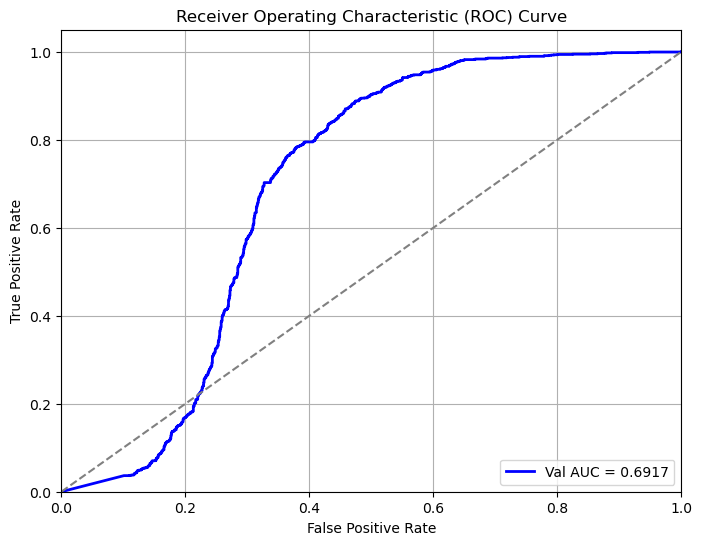

0.6916775298417812

In [45]:
test_with_graph(test_graph_data)

In [61]:
@torch.no_grad()
def test_model(data):
    model.eval()
    test_pred = model(data.x, data.edge_index)
    test_pred = test_pred.view(-1).cpu().numpy()
    test_labels = data.edge_label.cpu().numpy()
    return roc_auc_score(test_labels, test_pred)

In [62]:
def t():
    return test_model(test_graph_data)
train_model(200, t)


Epoch 1: Loss = 1.3279813528060913 Test = 0.77183851693051
Epoch 2: Loss = 0.08570228517055511 Test = 0.7619455497963054
Epoch 3: Loss = 1.4843741655349731 Test = 0.7629084159560057
Epoch 4: Loss = 0.1598929762840271 Test = 0.7666785767309973
Epoch 5: Loss = 0.1117204874753952 Test = 0.7691573928597263
Epoch 6: Loss = 0.18090511858463287 Test = 0.7737734945053272
Epoch 7: Loss = 0.24350430071353912 Test = 0.7784641020328141
Epoch 8: Loss = 0.28799787163734436 Test = 0.7836504184021914
Epoch 9: Loss = 0.3042531907558441 Test = 0.7897424978831084
Epoch 10: Loss = 0.2677585482597351 Test = 0.7911464171100311
Epoch 11: Loss = 0.2325126975774765 Test = 0.7923496599105604
Epoch 12: Loss = 0.17168083786964417 Test = 0.7936086461628656
Epoch 13: Loss = 0.13633331656455994 Test = 0.7937704381326542
Epoch 14: Loss = 0.12667852640151978 Test = 0.7936211544496055
Epoch 15: Loss = 0.1434887945652008 Test = 0.7944420787467349
Epoch 16: Loss = 0.15708069503307343 Test = 0.7953007998233612


KeyboardInterrupt: 

## limitation in dataset